In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

## Precipitation Analysis

In [18]:
#Find out the latest date in our data-set
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(latest_date)

('2017-08-23',)


In [19]:
#Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017,8,23) - dt.timedelta(days= 365)
print(year_ago)

2016-08-23


In [22]:
#Perform a query to retrieve the data and precipitation scores
precipitation_scores = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date>=year_ago, Measurement.prcp != None).\
    order_by(Measurement.date).all()

In [23]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precipitation_scores_df = pd.DataFrame(precipitation_scores, columns=['Date', 'Precipitation'])
precipitation_scores_df.set_index('Date', inplace=True)
precipitation_scores_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


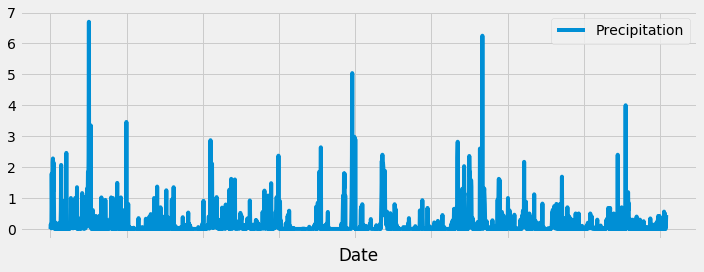

In [26]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_scores_df.plot(figsize =(10,4))
plt.tight_layout()
plt.savefig('Visualizations/Precipitation.png')

# Station Analysis

In [27]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_scores_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [29]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations available.".format(number_of_stations))

There are 9 stations available.


In [32]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [33]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temperatures = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                filter(Measurement.station == 'USC00519281').order_by(func.min(Measurement.tobs)).all()
temperatures

[(54.0, 85.0, 71.66378066378067)]

In [47]:
# Choose the station with the highest number of temperature observations. 
#Query the last 12 months of temperature observation data for this station
temp_observations = session.query(Measurement.tobs).\
                filter (Measurement.station == 'USC00519281').\
                filter(Measurement.date >= year_ago).\
                order_by(Measurement.date.desc()).all()

temp_observations_df = pd.DataFrame(temp_observations)
temp_observations_df.head()

,tobs
0,79.0
1,76.0
2,76.0
3,77.0
4,77.0


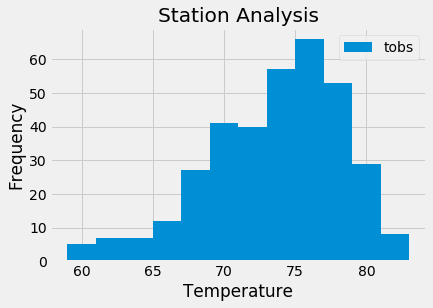

In [52]:
# Plot the results as a histogram
plt.hist(temp_observations_df['tobs'], bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title ("Station Analysis")
plt.legend(["tobs"])
plt.savefig('Visualizations/station-histogram.png')

## Climate App

In [53]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [55]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_year_start = dt.date(2018,1,1) - dt.timedelta(days= 365)
# print(prev_year_start)
prev_year_end = prev_year_start + dt.timedelta(days = 5)
#print(prev_year_end)
calc_temp = calc_temps(prev_year_start,prev_year_end)
print(calc_temp)

[(62.0, 68.05714285714286, 74.0)]


In [56]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
ta_temp= list(np.ravel(calc_temp))
#ta_temp
tmin = ta_temp[0]
tmax = ta_temp[2]
temp_avg = ta_temp[1]

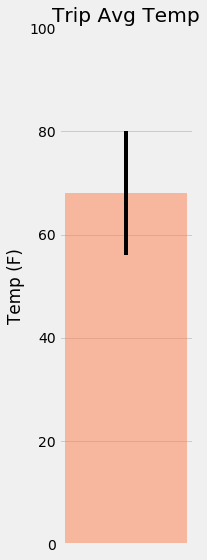

In [58]:
plt.figure(figsize=(3,8))
plt.bar(1,temp_avg, color = 'coral',alpha = 0.5)
plt.errorbar(1,temp_avg, yerr=(tmax - tmin), color = 'k')
plt.ylim(0, 100)
plt.xticks([])
plt.title('Trip Avg Temp')
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.savefig('Visualizations/average_temperature.png')

In [60]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_per_station = session.query(Station.station, Station.name, Station.latitude,
                                 Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
        filter(Measurement.date >= prev_year_start, Measurement.date <= prev_year_end).\
        filter(Measurement.prcp != None).\
        filter(Station.station == Measurement.station).\
        group_by(Measurement.station).\
        order_by(func.sum(Measurement.prcp).desc()).all()
print(rainfall_per_station)

[('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.61), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.6), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.6), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.29), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.2), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)]


## Optional Challenge Assignment

In [61]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [62]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

start_date=dt.datetime.strptime('2018-02-02', "%Y-%m-%d")
end_date=dt.datetime.strptime('2018-02-09', "%Y-%m-%d")
normals = []
dt_list = []

iter_date=start_date
while iter_date<=end_date:
    dt_list.append(iter_date)
    st_str_dt = iter_date.strftime("%m-%d")
    iter_date += dt.timedelta(1)
    normals.append(*daily_normals(st_str_dt))

normals

[(59.0, 68.85964912280701, 77.0),
 (58.0, 67.79661016949153, 77.0),
 (61.0, 68.14035087719299, 76.0),
 (59.0, 69.6842105263158, 80.0),
 (58.0, 70.38983050847457, 77.0),
 (60.0, 69.0, 77.0),
 (56.0, 66.75438596491227, 74.0),
 (57.0, 67.58928571428571, 75.0)]

In [63]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df2 = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
df2['Date'] = pd.to_datetime(dt_list)
df2.set_index('Date', inplace=True)
df2

,tmin,tavg,tmax
Date,,,
2018-02-02,59.0,68.859649,77.0
2018-02-03,58.0,67.796610,77.0
2018-02-04,61.0,68.140351,76.0
2018-02-05,59.0,69.684211,80.0
2018-02-06,58.0,70.389831,77.0
2018-02-07,60.0,69.000000,77.0
2018-02-08,56.0,66.754386,74.0
2018-02-09,57.0,67.589286,75.0


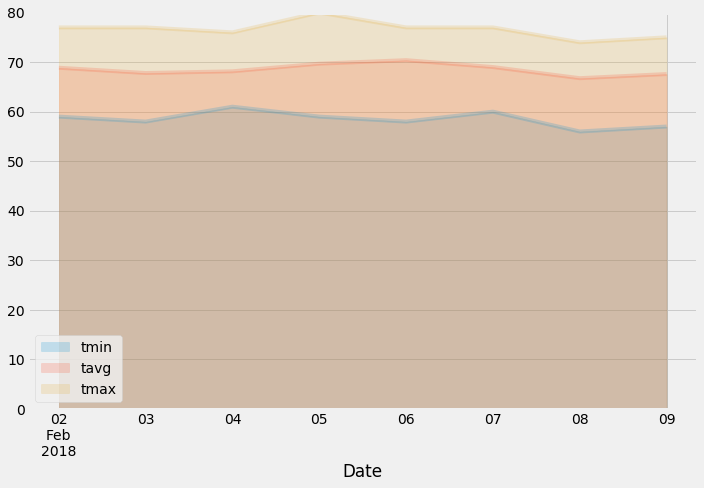

In [67]:
# Plot the daily normals as an area plot with `stacked=False`
df2.plot.area(stacked=False, alpha=0.2,figsize=(10,7))
plt.xlabel("Date")
plt.ylim(0, 80)
plt.tight_layout()
plt.savefig('Visualizations/daily_normals_plot.png')